<b>HOME WORK №1</b>

<u>задание №1</u><p>
<i>Для чего нужно понятие стационарности в анализе временных рядов?</i><p>
Нестационарный ряд невозможно прогнозировать. 
У стационарного ряда отсутствует тренд, дисперсия и мат ожидание постоянны. Прогнозные модели работают со стационарными рядами.
По теореме Вольда, для любого стационарного ряда можно подобрать ARMA p,q модель



<u>задание №2</u><p>
<i>Рассмотрите картинку data/images/ts_types.png</i><p>
a. Назовите ряды с гетероскедастичностью? <b>A, D, E, F, I </b><p>
b. Какие ряды имеют сезонность? <b>B, D(маловыраженная сезонность), G, H, I </b><p>
с. Какие ряды имеют цикличность? <b>B, D, G, H, I </b><p>
d. Какие ряды можно приблизить моделью интегрированного ряда? <b>A, B(этот ряд после diff), C, E, F </b><p>
e. Какие ряды можно считать стационарными? <b>B 


<u>задание №3</u><p>
<i>Рассмотрите один из графиков индекса Доу-Джонса (data/dataset/
dow_jones.csv). Предположим, вы можете сделать только одно
преобразование ряда, чтобы сделать его стационарным. Какое
преобразование вы выберете и почему? Сделайте это преобразование, 
проверьте, получили ли вы белый шум.</i><p>
<b>Диференцирование т.к. убирает тренд.</b>

In [34]:
dataset = Dataset('../data/dataset/')
ts = dataset['dow_jones_0.csv'].dropna()

adf:  -14.444371384539911
p-value:  7.270680965724108e-27
Critical values:  {'1%': -3.4569962781990573, '5%': -2.8732659015936024, '10%': -2.573018897632674}
единичных корней нет, ряд стационарен


<AxesSubplot:xlabel='2018-11-30'>

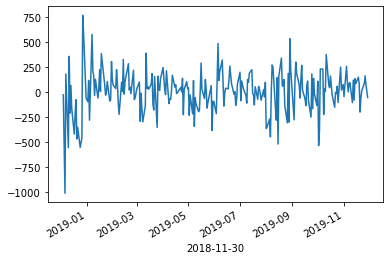

In [41]:
ts_diff = ts.diff()
test_adfuler(ts_diff)
ts_diff.plot()

<u>задание №4</u><p>
<i>Рассмотрите ряд data/dataset/stl_example.csv. Постройте для него
график автокорреляций. Обьясните закономерности, которые вы видите.</i><p>
<b>Ряд не стационарен. По графику автокорреляции видно сезонность на 6 и 7</b>

<AxesSubplot:>

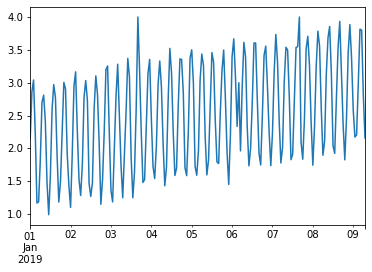

In [43]:
ts = dataset['stl_example.csv'].dropna()
ts.plot()

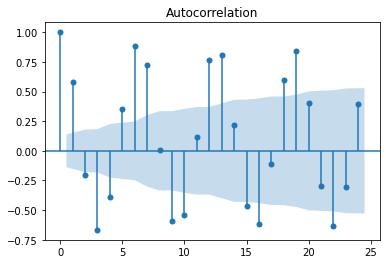

In [44]:
tsaplots.plot_acf(ts);

<u>задание №5</u><p>
<i>На семинаре, посвященном stl разложению мы находили период
сезонности сезонных временных рядов при помощи графика автокорреляций. 
Однако, если бы мы захотели построить автоматическую систему определения
периода, мы бы уже не могли “вручную” анализировать каждый график. Таким
образом вам необходимо написать функцию get_seasonal_period(), которая бы
автоматически определяла период сезонных временных рядов, использую
автокорреляционную функцию.</i>

(exp(2*1.96/√(N-3)-1)/(exp(2*1.96/√(N-3)+1)

In [203]:
from statsmodels.tsa.stattools import acf

In [429]:
def get_seasonal_period(data):
    period = np.array([])
    x = abs(acf(data)[1:])
    sort_x = np.sort(x)[:-6:-1] #берем 5 максимальных
    for n in sort_x:
        period = np.append(period, np.where(x == n)[0][0]+1)
    return int(period.min())

D:\Anaconda3\envs\ts_summer\lib\site-packages\statsmodels\tsa\stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
D:\Anaconda3\envs\ts_summer\lib\site-packages\statsmodels\tsa\stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,
6
adf:  -0.983451728816296
p-value:  0.7592519528940742
Critical values:  {'1%': -3.466005071659723, '5%': -2.8772078537639385, '10%': -2.5751221620996647}
есть единичные корни, ряд не стационарен


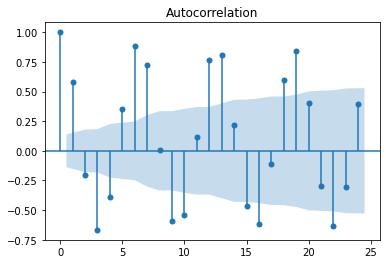

In [434]:
print(f'сезонный временной рget_seasonal_period(ts)')
tsaplots.plot_acf(ts);
test_adfuler(ts)

D:\Anaconda3\envs\ts_summer\lib\site-packages\statsmodels\tsa\stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
D:\Anaconda3\envs\ts_summer\lib\site-packages\statsmodels\tsa\stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,
3
adf:  -5.675967885485038
p-value:  8.703608585812594e-07
Critical values:  {'1%': -3.467631519151906, '5%': -2.8779183721695567, '10%': -2.575501353364474}
единичных корней нет, ряд стационарен


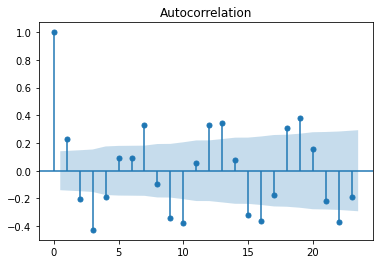

In [435]:
ts_diff_1 = ts.diff(6).dropna()
print (get_seasonal_period(ts_diff_1))
tsaplots.plot_acf(ts_diff_1);
test_adfuler(ts_diff_1)